# Data Preparation

The paper uses the Vietnamese data, which is present in the "data" directory of this project. We will later apply more preprocessing steps to generate tag mapping, word mapping and character  mapping. The data set contains 10 different types of named entities: PATIENT_ID, PERSON_NAME, AGE, GENDER, OCCUPATION, LOCATION, ORGANIZATION, SYMPTOM & DISEASE, TRANSPORTATION and DATE. Regarding the tagging scheme, we will use BIOES (the same with the one in the research paper); however, in order to serve the task of model evaluation and error extract we will use the BIO2 tagging scheme

BIOES tagging Scheme:

    B-X - Beginning of chunk X
    I-X - Inside of chunk X (not first or last)
    E-X - End of chunk X
    S-X - Single-token chunk X
    O - Outside of any chunk
  
BIO2 tagging scheme:
    B-X - Beginning of chunk X (can be first or last)
    I-X - Inside of chunk X (not first but can be last)
    O - Outside of any chunk

Example of Vietnamese-NER sentence available in the data:
    
    Đồng_thời O
    , O
    bệnh_viện O
    tiếp_tục O
    thực_hiện O
    các O
    biện_pháp O
    phòng_chống O
    dịch_bệnh O
    COVID O
    - O
    19 O
    theo O
    hướng_dẫn O
    của O
    Bộ B-ORGANIZATION
    Y_tế I-ORGANIZATION
    . O
    
Data Split(We use the same split as mentioned in paper, with the ratio of 50%, 20% and 30% for train, validation and test data, repesctively).:

    Training Data - train_word.conll
    Validation Data - dev_word.conll
    Testing Data - test_word.conll

Note: For the LSTM-CNN-CRF model we will use word data but not the syllable one. For example:
    
  Word data: The word "bệnh viện" will be considered as a single word those 2 words, "bệnh" and "viện", will be concatenated by an underscore: "bệnh viện" -> "bệnh_viện"

  Syllable data: The word "bệnh viện" will be considered as two separated words: "bệnh viện" -> "bệnh", "viện"

In [ ]:
!nvidia-smi

Wed Jun  4 09:47:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
%cd /content/drive/MyDrive/NLP project

In [ ]:
!pip install seaborn
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=444691acc1771735aa6344b3f66721aeb7e3070415ee129322ce8cd359880c22
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [ ]:
from __future__ import print_function
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
from torch import autograd

import time
import _pickle as cPickle

import urllib
import matplotlib.pyplot as plt
# import seaborn
# plt.rcParams['figure.dpi'] = 80
# plt.style.use('seaborn-pastel')

import os
import sys
import codecs
import re
import numpy as np

from seqeval.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

## Define constants and paramaters

We now define some constants and parameters that we will be using later

In [ ]:
parameters = OrderedDict()
parameters['train'] = './PhoNER_COVID19/data/word/train_word.conll' #Path to train file
parameters['dev'] = './PhoNER_COVID19/data/word/dev_word.conll' #Path to test file
parameters['test'] = './PhoNER_COVID19/data/word/test_word.conll' #Path to dev file
parameters['tag_scheme'] = "BIO" #BIO or BIOES
parameters['lower'] = True # Boolean variable to control lowercasing of words
parameters['zeros'] =  False # Chỉnh
parameters['char_dim'] = 100 #Char embedding dimension
parameters['word_dim'] = 300 #Token embedding dimension
parameters['word_lstm_dim'] = 200 #Chỉnh
parameters['word_bidirect'] = True #Use a bidirectional LSTM for words
parameters['embedding_path'] = "./PhoW2V/word2vec_vi_words_300dims.txt" #Location of pretrained embeddings
parameters['all_emb'] = 1 #Load all embeddings
parameters['crf'] =1 #Use CRF (0 to disable)
parameters['dropout'] = 0.75
parameters['epoch'] =  30 # giống trong paper
parameters['weights'] = "./End-to-end-Sequence-Labeling-via-Bi-directional-LSTM-CNNs-CRF-Tutorial/models/self-trained-model-1" #path to Pretrained for from a previous run
# parameters['name'] = "self-trained-model" # Model name
parameters['name'] = "model_word_version" # Model name
parameters['gradient_clip']=5.0
parameters['char_mode']="CNN"
models_path = "./End-to-end-Sequence-Labeling-via-Bi-directional-LSTM-CNNs-CRF-Tutorial/models/" #path to saved models

#GPU
parameters['use_gpu'] = torch.cuda.is_available() #GPU Check
use_gpu = parameters['use_gpu']

parameters['reload'] = False

#Constants
START_TAG = '<START>'
STOP_TAG = '<STOP>'

In [ ]:
#paths to files
#To stored mapping file
mapping_file = './End-to-end-Sequence-Labeling-via-Bi-directional-LSTM-CNNs-CRF-Tutorial/data/mapping.pkl'

#To stored model
name = parameters['name']
model_name = models_path + name #get_name(parameters)

if not os.path.exists(models_path):
    os.makedirs(models_path)

Check if the gpu is being used or not

In [ ]:
print(torch.cuda.is_available())

True


## Load data and preprocess

Firstly, the data is loaded from the train, dev and test files into a list of sentences.

Preprocessing:

    * All the digits in the words are replaced by 0
    
Why this preprocessing step?
    * For the Named Entity Recognition task, the information present in numerical digits doesnot help in predicting the entity. So, we replace all the digits by 0. So, now the model can concentrate on more important alphabets.

Note: For the task of error extraction, we will skip the process of replacing all digits by 0 -> parameters['zeros'] = False

In [ ]:
def zero_digits(string):
    # This function will replace all the digits in a string to 0s
    return re.sub('\d', '0', string)

def load_sentences(path, zeros):
    # A function help loading sentences from the dataset
    # A line in the dataset must contain at least 2 parts: word and its tag
    # In this project's dataset, a line only contains 2 parts: word and its NER tag (in BIO2 format)
    # A sentence is the combination of many lines (words) and each sentence gets separated by an empty line

    sentences = []
    sentence = []
    for line in codecs.open(path, 'r', 'utf8'):
        # If we want to replace the digits with zeros then by the time we read a line from a file we also replace the number(s) in that line with zero(s).
        # Otherwise we just read a line without replacing any numbers with zeros
        line = zero_digits(line.rstrip()) if zeros else line.rstrip()

        # Check for empty line = end of a sentence
        if not line:
            # We only add the sentence if it has word(s) inside
            if len(sentence) > 0:
                sentences.append(sentence)
                sentence = []
        # If not an empty line, keep adding words to form the full sentence
        else:
            word = line.split()
            assert len(word) >= 2     # Check to make sure that each line only has two parts: word and its NER tag
            sentence.append(word)

    # If we reach the end of the file but we still have not added the final sentence
    if len(sentence) > 0:
        sentences.append(sentence)
    return sentences

In [ ]:
train_sentences = load_sentences(parameters['train'], parameters['zeros'])
test_sentences = load_sentences(parameters['test'], parameters['zeros'])
dev_sentences = load_sentences(parameters['dev'], parameters['zeros'])

In [ ]:
print('The number of sentences in training set:',len(train_sentences))
print('The number of sentences in testing set:',len(test_sentences))
print('The number of sentences in development set:',len(dev_sentences))

The number of sentences in training set: 5027
The number of sentences in testing set: 3000
The number of sentences in development set: 2000


## Update tagging scheme

As mentioned before, we will only apply updating the tagging scheme from BIO2 to BIOES to match with the results in the reasearch paper. For the task of model evaluation, we will skip this update tagging scheme step.

In [ ]:
def iob2(tags):
    # This function serves 2 purposes:
    # 1. To check if the NER tag is in the BIO format: VALID -> PASS, INVALID -> STOP
    # 2. Update the tagging scheme from BIO1 to BIO2 format

    for i, tag in enumerate(tags):
        if tag == 'O':
            continue
        split = tag.split('-')
        if len(split) != 2 or split[0] not in ['I', 'B']:
            return False
        if split[0] == 'B':
            continue
        elif i == 0 or tags[i - 1] == 'O':  # conversion IOB1 to IOB2
            tags[i] = 'B' + tag[1:]
        elif tags[i - 1][1:] == tag[1:]:
            continue
        else:  # conversion IOB1 to IOB2
            tags[i] = 'B' + tag[1:]
    return True

def iob_iobes(tags):
    # This functions also serves 2 purposes:
    # 1. To check if the NER tag is in the BIO format: VALID -> PASS, INVALID -> STOP
    # 2. Update the tagging scheme from BIO2 to IOBES format

    new_tags = []
    for i, tag in enumerate(tags):
        if tag == 'O':
            new_tags.append(tag)
        elif tag.split('-')[0] == 'B':
            if i + 1 != len(tags) and \
               tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('B-', 'S-'))
        elif tag.split('-')[0] == 'I':
            if i + 1 < len(tags) and \
                    tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('I-', 'E-'))
        else:
            raise Exception('Invalid IOB format!')
    return new_tags

def update_tag_scheme(sentences, tag_scheme):
    # This function calls the 2 above functions:
    # Check if the tagging scheme in IOB format and update BIO1 to BIO2 format
    # Check if the tagging scheme in IOB format and update BIO2 to IOBES format

    for i, s in enumerate(sentences):
        tags = [w[-1] for w in s]
        # Check that tags are given in the BIO format
        if not iob2(tags):
            s_str = '\n'.join(' '.join(w) for w in s)
            raise Exception('Sentences should be given in BIO format! ' +
                            'Please check sentence %i:\n%s' % (i, s_str))
        if tag_scheme == 'BIOES':
            new_tags = iob_iobes(tags)
            for word, new_tag in zip(s, new_tags):
                word[-1] = new_tag
        else:
            pass

In [ ]:
update_tag_scheme(train_sentences, parameters['tag_scheme'])
update_tag_scheme(dev_sentences, parameters['tag_scheme'])
update_tag_scheme(test_sentences, parameters['tag_scheme'])

## Create Mappings for Words, Characters and Tags

In the step of applying mapping for words, characters in each words and tags, we want to map individual words, characters in each word and tags to unique numerical ID's.

## Why mapping is important?

With the indices for words, characters and tags, we will be able to employ matrix (tensors) operations inside the neural network architecture, which are significantly faster

In [ ]:
def create_item_dictionary(list_items):
    # This function will create a dictionary with:
    # + Key depends on the item in the list_items
    # + Value is the total number of time the value of the corresponding key appears

    assert type(list_items) is list
    item_dict = {}
    for items in list_items:
        for item in items:
            if item not in item_dict:
                item_dict[item] = 1
            else:
                item_dict[item] += 1
    return item_dict

def create_mapping(item_dict):
    # This function will help mapping based on the value of the item_dict:
    # The higher the value the smaller the index the key will have

    sorted_items = sorted(item_dict.items(), key=lambda x: (-x[1], x[0]))
    id_to_item = {index: item[0] for index, item in enumerate(sorted_items)}
    item_to_id = {item: index for index, item in id_to_item.items()}
    return item_to_id, id_to_item

def word_mapping(sentences, lower):
    # In this function, we will:
    # 1. Create a dictionary with key is each word and value is its total number of time appearing in the dataset
    # 2. Create mapping based on each value of the dictionary, the more a word appears the smaller index it will have

    words = [[word[0].lower() if lower else word[0] for word in sentence] for sentence in sentences]
    word_dict = create_item_dictionary(words)
    word_dict['<UNK>'] = 10000000 # <UNK> tag is for unknown words
    word_to_id, id_to_word = create_mapping(word_dict)
    print("Found %i unique words (%i in total)" % (
        len(word_dict), sum(len(word) for word in words)
    ))
    return word_dict, word_to_id, id_to_word

def char_mapping(sentences):
    # In this function, we will:
    # 1. Create a dictionary with key is each character and value is its total number of time appearing in the dataset
    # 2. Create mapping based on each value of the dictionary, the more a character appears the smaller index it will have

    chars = ["".join([word[0] for word in sentence]) for sentence in sentences]
    char_dict = create_item_dictionary(chars)
    char_to_id, id_to_char = create_mapping(char_dict)
    print("Found %i unique characters" % len(char_dict))
    return char_dict, char_to_id, id_to_char

def tag_mapping(sentences):
    # In this function, we will:
    # 1. Create a dictionary with key is each tag and value is its total number of time appearing in the dataset
    # 2. Create mapping based on each value of the dictionary, the more a tag appears the smaller index it will have

    tags = [[word[-1] for word in sentence] for sentence in sentences]
    tag_dict = create_item_dictionary(tags)
    tag_dict[START_TAG] = -1       # The index of the <START> tag will be the index right just before the final index (<STOP> tag)
    tag_dict[STOP_TAG] = -2        # The index of the <STOP> tag will be the final index
    tag_to_id, id_to_tag = create_mapping(tag_dict)
    print("Found %i unique named entity tags" % len(tag_dict))
    return tag_dict, tag_to_id, id_to_tag

In [ ]:
word_dict, word_to_id, id_to_word = word_mapping(train_sentences, parameters['lower'])
char_dict, char_to_id, id_to_char = char_mapping(train_sentences)
tag_dict, tag_to_id, id_to_tag = tag_mapping(train_sentences)

Found 4740 unique words (132511 in total)
Found 176 unique characters
Found 22 unique named entity tags


In [ ]:
# tag_to_id['I-NAME'] = 38
# tag_to_id

{'O': 0,
 'S-PATIENT_ID': 1,
 'B-LOCATION': 2,
 'E-LOCATION': 3,
 'S-LOCATION': 4,
 'I-LOCATION': 5,
 'I-ORGANIZATION': 6,
 'S-DATE': 7,
 'B-DATE': 8,
 'E-DATE': 9,
 'I-DATE': 10,
 'B-ORGANIZATION': 11,
 'E-ORGANIZATION': 12,
 'B-SYMPTOM_AND_DISEASE': 13,
 'E-SYMPTOM_AND_DISEASE': 14,
 'S-AGE': 15,
 'I-SYMPTOM_AND_DISEASE': 16,
 'S-GENDER': 17,
 'S-SYMPTOM_AND_DISEASE': 18,
 'S-NAME': 19,
 'S-TRANSPORTATION': 20,
 'S-JOB': 21,
 'B-TRANSPORTATION': 22,
 'E-TRANSPORTATION': 23,
 'S-ORGANIZATION': 24,
 'B-JOB': 25,
 'E-JOB': 26,
 'I-JOB': 27,
 'B-NAME': 28,
 'E-NAME': 29,
 'I-TRANSPORTATION': 30,
 'B-PATIENT_ID': 31,
 'E-PATIENT_ID': 32,
 'I-PATIENT_ID': 33,
 'B-AGE': 34,
 'E-AGE': 35,
 '<START>': 36,
 '<STOP>': 37,
 'I-NAME': 38}

## Preparing final dataset

The function prepare dataset returns a list of dictionaries ( one dictionary per each sentence ) -> Train sentence: 1 dictionary, Validation sentence: 1 dictionary, Test sentence: 1 dictionary

Each of the dictionary returned by the function contains:
    
    1. List of all words in the sentence (train, validation or test)
    2. List of word index for all words in the sentence
    3. List of lists, containing character id of each character for words in the sentence
    4. List of tag for each word in the sentence.

In [ ]:
def lower_case(word, lower=False):
    # Base on the "lower" parameter to lowercase a word or not
    if lower:
        return word.lower()
    else:
        return word

In [ ]:
def prepare_dataset(sentences, word_to_id, char_to_id, tag_to_id, lower=False):
    # A function to help us prepare the dataset, this function will return:
    # List of words in a sentence, words index, characters index, tags index -> For 1 sentence -> Store in a dictionary
    # The data variable will be a list and it will store the total number of sentences that appear in the dataset = the total number of dictionaries

    data = []
    for sentence in sentences:
        list_words = [item[0] for item in sentence]
        words_index = [word_to_id[lower_case(word,lower) if lower_case(word,lower) in word_to_id else '<UNK>']
                 for word in list_words]
        # Skip characters that are not in the training set
        chars_index = [[char_to_id[char] for char in word if char in char_to_id]
                 for word in list_words]
        tags_index = [tag_to_id[item[-1]] for item in sentence]
        data.append({
            'str_words': list_words,
            'words': words_index,
            'chars': chars_index,
            'tags': tags_index,
        })
    return data

train_data = prepare_dataset(
    train_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)
dev_data = prepare_dataset(
    dev_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)
test_data = prepare_dataset(
    test_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)
print("{} / {} / {} sentences in train / dev / test.".format(len(train_data), len(dev_data), len(test_data)))

5027 / 2000 / 3000 sentences in train / dev / test.


After the above step, the data is ready to be fitted to the model.

## Load Word Embeddings

Now, We move to the next step of loading the pre-trained word embeddings.

We will use Word-2-vec vectors with 300 dimensions pre-trained on a 20GB corpus of Vietnamese texts.

In [ ]:
all_word_embeds = {}
for i, line in enumerate(codecs.open(parameters['embedding_path'], 'r', 'utf-8')):
    s = line.strip().split()
    if len(s) == parameters['word_dim'] + 1:
        all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

#Intializing Word Embedding Matrix
word_embeds = np.random.uniform(-np.sqrt(0.06), np.sqrt(0.06), (len(word_to_id), parameters['word_dim']))

for w in word_to_id:
    if w in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w]
    elif w.lower() in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w.lower()]

print('Loaded %i pretrained embeddings.' % len(all_word_embeds))

Loaded 676322 pretrained embeddings.


## Storing Processed Data for Reuse

We can store the preprocessed data and the embedding matrix for future reuse. This helps us avoid the time taken by the step of preprocessing, when we are trying to tune the hyper parameters for the model.

In [ ]:
with open(mapping_file, 'wb') as f:
    mappings = {
        'word_to_id': word_to_id,
        'tag_to_id': tag_to_id,
        'char_to_id': char_to_id,
        'parameters': parameters,
        'word_embeds': word_embeds
    }
    cPickle.dump(mappings, f)

print('word_to_id: ', len(word_to_id))

word_to_id:  4740


In [ ]:
print('word_to_id: ', len(word_to_id))
print('tag_to_id:', len(tag_to_id))
print('char_to_id:', len(char_to_id))
print('parameters:', len(parameters))
print('word_embeds:', len(word_embeds))

word_to_id:  4740
tag_to_id: 22
char_to_id: 176
parameters: 21
word_embeds: 4740


# Buidling the model


The model that we are presenting is a complicated one, since its a hybridized network using LSTMs and CNNs. So in order to break down the complexity, we have attempted to simplify the process by splitting up operations into individual functions that we can go over part by part. This hopefully makes the whole thing more easily digestable and gives a more intuitive understanding of the whole process.

## Initialization of weights

We start with the init_embedding function, which just initializes the embedding layer by pooling from a random sample.

The distribution is pooled from $-\sqrt{\frac{3}{V}}$ to $+\sqrt{\frac{3}{V}}$ where $V$ is the embedding dimension size.

In [ ]:
def init_embedding(input_embedding):
    """
    Initialize embedding
    """
    bias = np.sqrt(3.0 / input_embedding.size(1))
    nn.init.uniform(input_embedding, -bias, bias)

Similar to the initialization above, except this is for the linear layer.

In [ ]:
def init_linear(input_linear):
    """
    Initialize linear transformation
    """
    bias = np.sqrt(6.0 / (input_linear.weight.size(0) + input_linear.weight.size(1)))
    nn.init.uniform(input_linear.weight, -bias, bias)
    if input_linear.bias is not None:
        input_linear.bias.data.zero_()

This is the initialization scheme for the LSTM layers.

The LSTM layers are initialized by uniform sampling from $-\sqrt{\frac{6}{r+c}}$ to $+\sqrt{\frac{6}{r+c}}$. Where $r$ is the number of rows, $c$ is the number of columns (based on the shape of the weight matrix).

In [ ]:
def init_lstm(input_lstm):
    """
    Initialize lstm

    PyTorch weights parameters:

        weight_ih_l[k]: the learnable input-hidden weights of the k-th layer,
            of shape `(hidden_size * input_size)` for `k = 0`. Otherwise, the shape is
            `(hidden_size * hidden_size)`

        weight_hh_l[k]: the learnable hidden-hidden weights of the k-th layer,
            of shape `(hidden_size * hidden_size)`
    """

    # Weights init for forward layer
    for ind in range(0, input_lstm.num_layers):

        ## Gets the weights Tensor from our model, for the input-hidden weights in our current layer
        weight = eval('input_lstm.weight_ih_l' + str(ind))

        # Initialize the sampling range
        sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))

        # Randomly sample from our samping range using uniform distribution and apply it to our current layer
        nn.init.uniform(weight, -sampling_range, sampling_range)

        # Similar to above but for the hidden-hidden weights of the current layer
        weight = eval('input_lstm.weight_hh_l' + str(ind))
        sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
        nn.init.uniform(weight, -sampling_range, sampling_range)


    # We do the above again, for the backward layer if we are using a bi-directional LSTM (our final model uses this)
    if input_lstm.bidirectional:
        for ind in range(0, input_lstm.num_layers):
            weight = eval('input_lstm.weight_ih_l' + str(ind) + '_reverse')
            sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform(weight, -sampling_range, sampling_range)
            weight = eval('input_lstm.weight_hh_l' + str(ind) + '_reverse')
            sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform(weight, -sampling_range, sampling_range)

    # Bias initialization steps

    # We initialize them to zero except for the forget gate bias, which is initialized to 1
    if input_lstm.bias:
        for ind in range(0, input_lstm.num_layers):
            bias = eval('input_lstm.bias_ih_l' + str(ind))

            # Initializing to zero
            bias.data.zero_()

            # This is the range of indices for our forget gates for each LSTM cell
            bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1

            #Similar for the hidden-hidden layer
            bias = eval('input_lstm.bias_hh_l' + str(ind))
            bias.data.zero_()
            bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1

        # Similar to above, we do for backward layer if we are using a bi-directional LSTM
        if input_lstm.bidirectional:
            for ind in range(0, input_lstm.num_layers):
                bias = eval('input_lstm.bias_ih_l' + str(ind) + '_reverse')
                bias.data.zero_()
                bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
                bias = eval('input_lstm.bias_hh_l' + str(ind) + '_reverse')
                bias.data.zero_()
                bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1

## CRF Layer

- Without the CRF Layer the model can already predicted the labels but the accuracy score would be considerably low since there are no rules or constraint for the model to know which tags should not follow some tags.
- With the help the CRF layer, it will apply some rules relate to the tags so that the model will predict the labels much more precisely.
- For example: CRF layer will add a rule that B-PERSON cannot be followed by I-ORGANIZATION.

## Evaluation schemes: Forward pass and Viterbi algorithm

- The forward pass will help us calculate the score of all possible paths.
- The viterbi algorithm will help us calculate not only the score of the best path but also the best path itself.

## Helper Functions

Now, we define some helper functions for numerical operations and score calculations

In [ ]:
def log_sum_exp(vec):
    # This function applies log, sum and exp to calculate the score of all possible paths
    # Before applying the log, sum and exp, we need to turn the score to numerically stable version in order to avoid the overflow situation
    # vec's size: (1, tagset_size)

    # print("Arg max of vec: ", argmax(vec))

    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

def argmax(vec):
    # This function will return the index of the max value in a vector

    _, index = torch.max(vec, 1) # idx is a tensor and inside of it only has 1 value
    return to_scalar(index)

def to_scalar(var):
    '''
    Function to convert pytorch tensor to a scalar
    '''

    # This function will turn a tensor to a scalar:
    # Step 1: Flatten the tensor to a 1-D array
    # Step 2: Pick the first element of the array

    return var.view(-1).data.tolist()[0]

## Helper function to calculate score

This is a score function for our sentences.

This function takes two things, a list of ground truths that tell us what the corresponding tags are, the other are the features which contains the supposed tagged parts of the function. Which is then used to compute the score.

This function will calculate the score of the ground truth path.

In [ ]:
def score_sentences(self, feats, tags):
    # This function calculates the score of the correct sequence of tags
    # tags is ground_truth, a list of ints, length is len(sentence)
    # feats is a 2D tensor, with the size of: len(sentence) * tagset_size


    r = torch.LongTensor(range(feats.size()[0]))    # range(number_of_words_in_1_sentence)
    if self.use_gpu:
        r = r.cuda()
        pad_start_tags = torch.cat([torch.cuda.LongTensor([self.tag_to_ix[START_TAG]]), tags])
        pad_stop_tags = torch.cat([tags, torch.cuda.LongTensor([self.tag_to_ix[STOP_TAG]])])
    else:
        pad_start_tags = torch.cat([torch.LongTensor([self.tag_to_ix[START_TAG]]), tags])
        pad_stop_tags = torch.cat([tags, torch.LongTensor([self.tag_to_ix[STOP_TAG]])])

    # print("Transition scores: ", self.transitions[pad_stop_tags, pad_start_tags])

    # score = trans_score + emit_score
    score = torch.sum(self.transitions[pad_stop_tags, pad_start_tags]) + torch.sum(feats[r, tags])

    return score

## Implementation of Forward Algorithm

In [ ]:
def forward_alg(self, feats):
    # This function calculates the score of all possible paths that a sentence can have or the partition function
    # feats has the size of: len(sentence) * tagset_size

    # Initialize alpha with a Tensor (with the size of (1, len(tagset_size))) with values all equal to -10000.
    alpha = torch.Tensor(1, self.tagset_size).fill_(-10000.)

    # START_TAG = 0 means it will start with the <START> tag
    alpha[0][self.tag_to_ix[START_TAG]] = 0.

    # Wrap in a variable so that we will get automatic backpropagation
    forward_var = autograd.Variable(alpha)
    if self.use_gpu:
        forward_var = forward_var.cuda()

    # Iterate through the sentence
    for feat in feats:
        # Broadcast the emission score to a tensor with the size of (len(tagset_size), 1)
        emit_score = feat.view(-1, 1)

        # Adding the transition score and emission score to the forward variable
        tag_var = forward_var + self.transitions + emit_score

        # Before applying the log, sum, exp function to the score above, we need to turn it numerically stable version
        max_tag_var, _ = torch.max(tag_var, dim=1)
        tag_var = tag_var - max_tag_var.view(-1, 1)

        # After turning the score to a numerically stable version, we can apply log, sum, exp to the score
        forward_var = max_tag_var + torch.log(torch.sum(torch.exp(tag_var), dim=1)).view(1, -1) # ).view(1, -1)


    # Adding the transition score to the <STOP> tag before applying the log, sum, exp function the last time
    terminal_var = (forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]).view(1, -1)
    alpha = log_sum_exp(terminal_var)
    # Z(x)
    return alpha

## Viterbi decode

- Viterbi will calculate the scores of all possible paths and in the mean time it also stores the index of the tags that have the highes score to a back pointer.
- The best score will be the final maximum score.
- We will locate the index of the tag that has the maximum score and with the help of the back pointer we will be able to find the best path.

In [ ]:
def viterbi_algo(self, feats):
    # In this function we will implement the viterbi algorithm to find the best sequence of tags of a sentence

    # A list to store the index of the best previous tag for the current tag
    backpointers = []

    # Initialize the viterbi variables in log space
    init_variable = torch.Tensor(1, self.tagset_size).fill_(-10000.)

    # START_TAG = 0 means it will start with the <START> tag
    init_variable[0][self.tag_to_ix[START_TAG]] = 0

    # forward_var at step i holds the viterbi variables for step i-1
    forward_var = Variable(init_variable)
    if self.use_gpu:
        forward_var = forward_var.cuda()
    for feat in feats:
        next_tag_var = forward_var.view(1, -1).expand(self.tagset_size, self.tagset_size) + self.transitions
        _, back_pointer = torch.max(next_tag_var, dim=1)
        back_pointer = back_pointer.squeeze().data.cpu().numpy() # holds the backpointers for this step
        next_tag_var = next_tag_var.data.cpu().numpy()
        viterbivars_t = next_tag_var[range(len(back_pointer)), back_pointer] # holds the viterbi variables for this step
        viterbivars_t = Variable(torch.FloatTensor(viterbivars_t))
        if self.use_gpu:
            viterbivars_t = viterbivars_t.cuda()

        # Update the Viterbi score by adding the emission score here
        forward_var = viterbivars_t + feat
        backpointers.append(back_pointer)

    # Add the forward variable with the transition score to STOP_TAG
    terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
    terminal_var.data[self.tag_to_ix[STOP_TAG]] = -10000.
    terminal_var.data[self.tag_to_ix[START_TAG]] = -10000.
    best_tag_id = argmax(terminal_var.unsqueeze(0))
    path_score = terminal_var[best_tag_id]

    # Follow the back pointers to decode the best path.
    best_path = [best_tag_id]
    for bptrs_t in reversed(backpointers):
        best_tag_id = bptrs_t[best_tag_id]
        best_path.append(best_tag_id)

    # Pop off the start tag
    start = best_path.pop()
    assert start == self.tag_to_ix[START_TAG] # Make sure that we remove the start tag
    best_path.reverse()
    return path_score, best_path

The below function will be used to call the viterbi algorithm

In [ ]:
def forward_calc(self, sentence, chars, chars2_length):
    # This function calls the above viterbi algorithm to return the best sequence of tags

    # Get the emission scores from the BiLSTM model
    # feats = self._get_lstm_features(sentence, chars, chars2_length, d)
    feats = self._get_lstm_features(sentence, chars, chars2_length)


    # With the given features, apply the viterbi algorithm to find the best path
    if self.use_crf:
        score, tag_seq = self.viterbi_decode(feats)
    else:
        score, tag_seq = torch.max(feats, 1)
        tag_seq = list(tag_seq.cpu().data)

    return score, tag_seq

## Details fo the Model

##### 1. CNN model for generating character embeddings


Consider the word 'cat', we pad it on both ends to get our maximum word length ( this is mainly an implementation quirk since we can't have variable length layers at run time, our algorithm will ignore the pads).

We then apply a convolution layer on top that generates spatial coherence across characters, we use a maxpool to extract meaningful features out of our convolution layer. This now gives us a dense vector representation of each word. This representation will be concatenated with the pre-trained GloVe embeddings using a simple lookup.


<img src = "https://github.com/TheAnig/NER-LSTM-CNN-Pytorch/raw/master/images/cnn_model.png"></img>
<a href="http://www.aclweb.org/anthology/P16-1101">Image Source</a>


This snippet shows us how the CNN is implemented in pytorch

`self.char_cnn3 = nn.Conv2d(in_channels=1, out_channels=self.out_channels, kernel_size=(3, char_embedding_dim), padding=(2,0))`

##### 2. Rest of the model (LSTM based) that generates tags for the given sequence

The word-embeddings( glove+char embedding ) that we generated above, we feed to a bi-directional LSTM model. The LSTM model has 2 layers,
* The forward layer takes in a sequence of word vectors and generates a new vector based on what it has seen so far in the forward direction (starting from the start word up until current word) this vector can be thought of as a summary of all the words it has seen.

* The backwards layer does the same but in opposite direction, i.e., from the end of the sentence to the current word.

The forward vector and the backwards vector at current word concatanate to generate a unified representation.

<img src = "https://github.com/TheAnig/NER-LSTM-CNN-Pytorch/raw/master/images/lstm_model.png"></img>
<a href="http://www.aclweb.org/anthology/P16-1101">Image Source</a>

This snippet shows us how the BiLSTM is implemented in pytorch

`self.lstm = nn.LSTM(embedding_dim+self.out_channels, hidden_dim, bidirectional=True)`

Finally, we have a linear layer to map hidden vectors to tag space.

##### Main Model Implementation

The get_lstm_features function returns the LSTM's tag vectors. The function performs all the steps mentioned above for the model.

Steps:
1. It takes in Characters Embedding, reshapes its size to prepare for 2D convolution. The CNN extracts local features (trigrams here) from the sequence of character embeddings, capturing patterns like prefixes, suffixes, or syllable structures that are relevant for NER. Max pooling will then be applied to select the most salient features from the CNN output. This will produce the Character-level representation.
2. We concat Character-level representation with Word Embedding, use this as features that we feed to Bidirectional-LSTM.
3. The Bidirectional-LSTM generates outputs based on these set of features.
4. The outputs are passed through a linear layer to convert to tag space.

In [ ]:
def get_lstm_features(self, sentence, chars2, chars2_length):

    # if self.char_mode == 'LSTM':

    #         chars_embeds = self.char_embeds(chars2).transpose(0, 1)

    #         packed = torch.nn.utils.rnn.pack_padded_sequence(chars_embeds, chars2_length)

    #         lstm_out, _ = self.char_lstm(packed)

    #         outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(lstm_out)

    #         outputs = outputs.transpose(0, 1)

    #         chars_embeds_temp = Variable(torch.FloatTensor(torch.zeros((outputs.size(0), outputs.size(2)))))

    #         if self.use_gpu:
    #             chars_embeds_temp = chars_embeds_temp.cuda()

    #         for i, index in enumerate(output_lengths):
    #             chars_embeds_temp[i] = torch.cat((outputs[i, index-1, :self.char_lstm_dim], outputs[i, 0, self.char_lstm_dim:]))

    #         chars_embeds = chars_embeds_temp.clone()

    #         for i in range(chars_embeds.size(0)):
    #             chars_embeds[d[i]] = chars_embeds_temp[i]


    if self.char_mode == 'CNN':
        chars_embeds = self.char_embeds(chars2).unsqueeze(1)

        ## Creating Character level representation using Convolutional Neural Netowrk
        ## followed by a Maxpooling Layer
        chars_cnn_out3 = self.char_cnn3(chars_embeds)
        chars_embeds = nn.functional.max_pool2d(chars_cnn_out3,
                                             kernel_size=(chars_cnn_out3.size(2), 1)).view(chars_cnn_out3.size(0), self.out_channels)

        ## Loading word embeddings
    embeds = self.word_embeds(sentence)

    ## We concatenate the word embeddings and the character level representation
    ## to create unified representation for each word
    embeds = torch.cat((embeds, chars_embeds), 1)

    embeds = embeds.unsqueeze(1)

    ## Dropout on the unified embeddings
    embeds = self.dropout(embeds)

    ## Word lstm
    ## Takes words as input and generates a output at each step
    lstm_out, _ = self.lstm(embeds)

    ## Reshaping the outputs from the lstm layer
    lstm_out = lstm_out.view(len(sentence), self.hidden_dim*2)

    ## Dropout on the lstm output
    lstm_out = self.dropout(lstm_out)

    ## Linear layer converts the ouput vectors to tag space
    lstm_feats = self.hidden2tag(lstm_out)

    return lstm_feats

##### Funtion for Negative log likelihood calculation

This is a helper function that calculates the negative log likelihood.

- This function will first calculate the emission matrix score which is the output of the Bi-LSTM.
- Next, it will calculate the score of all posible paths by using the above forward algorithm
- Next, it will calculate the score of the ground truth path by using the above score sentence
- Finally, it will calculate the negative log likelihood value (loss value) by subtracting the score of all possible paths by the score of ground truth path.
- We will then base on this loss value or negative log likelihood value to optimize the model.

In [ ]:
def get_neg_log_likelihood(self, sentence, tags, chars2, chars2_length):
    # sentence, tags is a list of ints
    # features is a 2D tensor, len(sentence) * self.tagset_size

    # feats = self._get_lstm_features(sentence, chars2, chars2_length, d)

    feats = self._get_lstm_features(sentence, chars2, chars2_length)

    if self.use_crf:
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score
    else:
        tags = Variable(tags)
        scores = nn.functional.cross_entropy(feats, tags)
        return scores

##### Main Model Class

In [ ]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,
                 char_to_ix=None, pre_word_embeds=None, char_out_dimension=25,char_embedding_dim=25, use_gpu=False
                 , use_crf=True, char_mode='CNN'):
        '''
        Input parameters:

                vocab_size= Size of vocabulary (int)
                tag_to_ix = Dictionary that maps NER tags to indices
                embedding_dim = Dimension of word embeddings (int)
                hidden_dim = The hidden dimension of the LSTM layer (int)
                char_to_ix = Dictionary that maps characters to indices
                pre_word_embeds = Numpy array which provides mapping from word embeddings to word indices
                char_out_dimension = Output dimension from the CNN encoder for character
                char_embedding_dim = Dimension of the character embeddings
                use_gpu = defines availability of GPU,
                    when True: CUDA function calls are made
                    else: Normal CPU function calls are made
                use_crf = parameter which decides if you want to use the CRF layer for output decoding
        '''

        super(BiLSTM_CRF, self).__init__()

        #parameter initialization for the model
        self.use_gpu = use_gpu
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.use_crf = use_crf
        self.tagset_size = len(tag_to_ix)
        self.out_channels = char_out_dimension
        self.char_mode = char_mode

        if char_embedding_dim is not None:
            self.char_embedding_dim = char_embedding_dim

            #Initializing the character embedding layer
            self.char_embeds = nn.Embedding(len(char_to_ix), char_embedding_dim)
            init_embedding(self.char_embeds.weight)

            #Performing LSTM encoding on the character embeddings
            # if self.char_mode == 'LSTM':
            #     self.char_lstm = nn.LSTM(char_embedding_dim, char_lstm_dim, num_layers=1, bidirectional=True)
            #     init_lstm(self.char_lstm)

            #Performing CNN encoding on the character embeddings
            if self.char_mode == 'CNN':
                self.char_cnn3 = nn.Conv2d(in_channels=1, out_channels=self.out_channels, kernel_size=(3, char_embedding_dim), padding=(2,0))

        #Creating Embedding layer with dimension of ( number of words * dimension of each word)
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        if pre_word_embeds is not None:
            #Initializes the word embeddings with pretrained word embeddings
            self.pre_word_embeds = True
            self.word_embeds.weight = nn.Parameter(torch.FloatTensor(pre_word_embeds))
        else:
            self.pre_word_embeds = False

        #Initializing the dropout layer, with dropout specificed in parameters
        self.dropout = nn.Dropout(parameters['dropout'])

        #Lstm Layer:
        #input dimension: word embedding dimension + character level representation
        #bidirectional=True, specifies that we are using the bidirectional LSTM
        # if self.char_mode == 'LSTM':
        #     self.lstm = nn.LSTM(embedding_dim+char_lstm_dim*2, hidden_dim, bidirectional=True)

        if self.char_mode == 'CNN':
            self.lstm = nn.LSTM(embedding_dim+self.out_channels, hidden_dim, bidirectional=True)

        #Initializing the lstm layer using predefined function for initialization
        init_lstm(self.lstm)

        # Linear layer which maps the output of the bidirectional LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)

        #Initializing the linear layer using predefined function for initialization
        init_linear(self.hidden2tag)

        if self.use_crf:
            # Matrix of transition parameters.  Entry i,j is the score of transitioning *to* i *from* j.
            # Matrix has a dimension of (total number of tags * total number of tags)
            self.transitions = nn.Parameter(
                torch.zeros(self.tagset_size, self.tagset_size))

            # These two statements enforce the constraint that we never transfer
            # to the start tag and we never transfer from the stop tag
            self.transitions.data[tag_to_ix[START_TAG], :] = -10000
            self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

    #assigning the functions, which we have defined earlier
    _score_sentence = score_sentences
    _get_lstm_features = get_lstm_features
    _forward_alg = forward_alg
    viterbi_decode = viterbi_algo
    neg_log_likelihood = get_neg_log_likelihood
    forward = forward_calc

##### Model initialiaztion

In [ ]:
#creating the model using the Class defined above
model = BiLSTM_CRF(vocab_size=len(word_to_id),
                   tag_to_ix=tag_to_id,
                   embedding_dim=parameters['word_dim'],
                   hidden_dim=parameters['word_lstm_dim'],
                   use_gpu=use_gpu,
                   char_to_ix=char_to_id,
                   pre_word_embeds=word_embeds,
                   use_crf=parameters['crf'],
                   char_mode=parameters['char_mode'],
                   char_out_dimension = 50)
print("Model Initialized!!!")

Model Initialized!!!


<ipython-input-20-db3aa24d91b1>:6: FutureWarning: `nn.init.uniform` is now deprecated in favor of `nn.init.uniform_`.
  nn.init.uniform(input_embedding, -bias, bias)
<ipython-input-22-c489f95df697>:25: FutureWarning: `nn.init.uniform` is now deprecated in favor of `nn.init.uniform_`.
  nn.init.uniform(weight, -sampling_range, sampling_range)
<ipython-input-22-c489f95df697>:30: FutureWarning: `nn.init.uniform` is now deprecated in favor of `nn.init.uniform_`.
  nn.init.uniform(weight, -sampling_range, sampling_range)
<ipython-input-22-c489f95df697>:38: FutureWarning: `nn.init.uniform` is now deprecated in favor of `nn.init.uniform_`.
  nn.init.uniform(weight, -sampling_range, sampling_range)
<ipython-input-22-c489f95df697>:41: FutureWarning: `nn.init.uniform` is now deprecated in favor of `nn.init.uniform_`.
  nn.init.uniform(weight, -sampling_range, sampling_range)


##### Check model's paramters and switch the model to run on GPU

In [ ]:
# Print the model's parameters

for name, param in model.named_parameters():
  print(name)

if use_gpu:
    # model.cuda()
    print(model.cuda())

# print(f"Model's parameters after: {model.parameters}")

transitions
char_embeds.weight
char_cnn3.weight
char_cnn3.bias
word_embeds.weight
lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
lstm.weight_ih_l0_reverse
lstm.weight_hh_l0_reverse
lstm.bias_ih_l0_reverse
lstm.bias_hh_l0_reverse
hidden2tag.weight
hidden2tag.bias
BiLSTM_CRF(
  (char_embeds): Embedding(176, 25)
  (char_cnn3): Conv2d(1, 50, kernel_size=(3, 25), stride=(1, 1), padding=(2, 0))
  (word_embeds): Embedding(4740, 300)
  (dropout): Dropout(p=0.75, inplace=False)
  (lstm): LSTM(350, 200, bidirectional=True)
  (hidden2tag): Linear(in_features=400, out_features=22, bias=True)
)


# Evaluation
- This evaluating step will also be used during the training process to:
  - Evaluate the model
  - Calculate the F1 score on the validation set to find the best F1 score in order to save to the model

## We will define 2 helper functions for the evaluation function
Those 2 functions are:
- get_chunk_type: This function will help us split the entity tag into 2 parts: entity class (B, I, O, E or S) and entity type (PATIENT_ID, PERSON_NAME, AGE, ...)
- get_chunks: This function will help us change the format of the output of the entire model, which is a sequence of tag's ids in a sentence, to a more convient one to evaluate the model. Specifically, this function will turn the sequence of tag's ids to a list of tuples and in each of those tuples will have three item:
  - chunk_type: Which is the type of the entity
  - chunk_start: Which is the start index of the entity type in the sentence
  - chunk_end: Which is the end index of the entity type in the sentence. Please note that the chunk_index is excluded which means that the entity type will start at the index of chunk_start and end at the index of chunk_end - 1

In [ ]:
def get_chunk_type(tok, idx_to_tag):
    # This function takes in 2 arguments:
    # tok: id of the entity tag, for example: 2
    # idx_to_tag: a dictionary with key is the id and the value is the corresponding entity tag (For example: key: 1, value: "B-PERSON_NAME")

    # This function helps us splitting the entity tag (chunk) into 2 parts, after achieving the entity tag by passing the tok to idx_to_tag
    # The 2 parts:
    # + The type part: B, I, O, E or S
    # + The class part: PATIENT_ID, PERSON_NAME, AGE, LOCATION,...

    # We pass in the id of the tag to get the tag name
    tag_name = idx_to_tag[tok]

    # We split the tag name into 2 parts:
    # The class: B, I, O, E, S
    tag_class = tag_name.split('-')[0]

    # The type: PATIENT_ID, PERSON_NAME, AGE, GENDER, LOCATION,...
    tag_type = tag_name.split('-')[-1]

    return tag_class, tag_type

In [ ]:
def get_chunks(seq, tags):
    # This function takes in 2 arguments:
    # seq: Sequence of ids of the tags with the length = len(sentence)
    # tags: a dictionary with key is the tag name and the value is its corresponding id

    # This function will return:
    # A list of tuple (chunks) and in each tuple (chunk) there are three items: chunk_type, chunk_start, chunk_end + 1
    # For example: chunk = (PERSON, 0, 3) -> The "PERSON" type will start at the index 0 and end at the index of 2 in the sentence
    # Please note that this function only consider entity as a chunk, those with O chunk_type are not considered chunks.

    # We assume by default the tags lie outside a named entity
    default = tags["O"]

    # Store the tag_to_id dictionary's key (tag) and value (id)
    # as a dictionary with key is the id and the value is the tag
    idx_to_tag = {idx: tag for tag, idx in tags.items()}

    chunks = []

    # This variable will store the type of chunk
    chunk_type = None

    # This variable will store the start index of the type chunk
    chunk_start = None

    for i, tok in enumerate(seq):
        # End of a chunk 1
        if tok == default and chunk_type is not None:
            # Add a chunk.
            chunk = (chunk_type, chunk_start, i)
            chunks.append(chunk)
            chunk_type, chunk_start = None, None

        # End of a chunk + start of a chunk!
        elif tok != default:
            tok_chunk_class, tok_chunk_type = get_chunk_type(tok, idx_to_tag)
            if chunk_type is None:
                # Initialize chunk for each entity
                chunk_type, chunk_start = tok_chunk_type, i
            elif tok_chunk_type != chunk_type or tok_chunk_class == "B":
                # If chunk class is B, i.e., its a beginning of a new named entity
                # or, if the chunk type is different from the previous one, then we
                # start labelling it as a new entity
                chunk = (chunk_type, chunk_start, i)
                chunks.append(chunk)
                chunk_type, chunk_start = tok_chunk_type, i
        else:
            pass

    # A condition to check if the entity (chunk) lies at the end of a sentence
    if chunk_type is not None:
        chunk = (chunk_type, chunk_start, len(seq))
        chunks.append(chunk)

    return chunks

With the help of the 2 above functions, we can now implement the evaluating function

In [ ]:
def evaluating(model, datas, best_F,dataset="Train"):
    '''
    The function takes as input the model, data and calcuates F-1 Score
    It performs conditional updates
     1) Flag to save the model
     2) Best F-1 score
    ,if the F-1 score calculated improves on the previous F-1 score
    '''
    # Initializations
    prediction = [] # A list that stores predicted tags
    save = False # Flag that tells us if the model needs to be saved
    new_F = 0.0 # Variable to store the current F1-Score (may not be the best)
    correct_preds, total_correct, total_preds = 0., 0., 0. # Count variables

    for data in datas:
        ground_truth_id = data['tags']
        words = data['str_words']
        chars2 = data['chars']

        # if parameters['char_mode'] == 'LSTM':
        #     chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
        #     d = {}
        #     for i, ci in enumerate(chars2):
        #         for j, cj in enumerate(chars2_sorted):
        #             if ci == cj and not j in d and not i in d.values():
        #                 d[j] = i
        #                 continue
        #     chars2_length = [len(c) for c in chars2_sorted]
        #     char_maxl = max(chars2_length)
        #     chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
        #     for i, c in enumerate(chars2_sorted):
        #         chars2_mask[i, :chars2_length[i]] = c
        #     chars2_mask = Variable(torch.LongTensor(chars2_mask))

        if parameters['char_mode'] == 'CNN':
            # Padding the each word to max word size of that sentence
            chars2_length = [len(c) for c in chars2]
            char_maxl = max(chars2_length)
            chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
            for i, c in enumerate(chars2):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))

        dwords = Variable(torch.LongTensor(data['words']))

        # We are getting the predicted output from our model
        if use_gpu:
            val,predict_tag_id = model(dwords.cuda(), chars2_mask.cuda(), chars2_length)
        else:
            val,predict_tag_id = model(dwords, chars2_mask, chars2_length)

        # We use the get chunks function defined above to get the true chunks
        # and the predicted chunks from true labels and predicted labels respectively
        lab_chunks      = set(get_chunks(ground_truth_id,tag_to_id))
        lab_pred_chunks = set(get_chunks(predict_tag_id,
                                         tag_to_id))

        # Updating the count variables
        # By implementing intersection between the 2 sets (ground-truth and prediction), we will get the total number of correct predictions
        correct_preds += len(lab_chunks & lab_pred_chunks)

        # Update the number of predictions
        total_preds   += len(lab_pred_chunks)

        # Update the number of labels
        total_correct += len(lab_chunks)

    # Calculating the F1-Score
    # F1 tính kiểu này là tính theo micro
    # micro là tính toàn bộ không phân biệt class
    # macro là lấy trung bình f1 của các class
    p   = correct_preds / total_preds if correct_preds > 0 else 0
    r   = correct_preds / total_correct if correct_preds > 0 else 0
    new_F  = 2 * p * r / (p + r) if correct_preds > 0 else 0

    print("{}: new_F: {} best_F: {} ".format(dataset,new_F,best_F))

    # If our current F1-Score is better than the previous best, we update the best
    # to current F1 and we set the flag to indicate that we need to checkpoint this model

    if new_F>best_F:
        best_F=new_F
        save=True

    return best_F, new_F, save

# TRAINING

## Training paramters which will be used during the training process

In [ ]:
learning_rate = 0.001 # the same as VinAI paper
number_of_epochs = parameters['epoch']
decay_rate = 0.05
gradient_clip = parameters['gradient_clip']
# VinAI dùng Adam
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate, betas=(0.9, 0.999))

#variables which will used in training process
losses = [] #list to store all losses
loss = 0.0 #Loss Initializatoin
best_dev_F = -1.0 # Current best F-1 Score on Dev Set
best_train_F = -1.0 # Current best F-1 Score on Train Set
eval_every = len(train_data) # Calculate F-1 Score after this many iterations
plot_every = 2000 # Store loss after this many iterations
count = 0 #Counts the number of iterations

## A helper function to adjust the learning rate during the training process

In [ ]:
def adjust_learning_rate(optimizer, lr):
    """
    shrink learning rate
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## Training time

If `parameters['reload']` is set, we already have a model to load of off, so we can skip the training. We have originally specified a pre-trained model since training is an expensive process, but we encourage readers to try this out once they're done with the tutorial.

<ipython-input-24-ce1760f04c8d>:10: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  pad_start_tags = torch.cat([torch.cuda.LongTensor([self.tag_to_ix[START_TAG]]), tags])
<ipython-input-38-0a1329fe7eb9>:56: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), gradient_clip)


2000 :  tensor(0.4106, device='cuda:0')
4000 :  tensor(0.1354, device='cuda:0')
6000 :  tensor(0.1016, device='cuda:0')
8000 :  tensor(0.0782, device='cuda:0')
10000 :  tensor(0.0733, device='cuda:0')
12000 :  tensor(0.0575, device='cuda:0')
14000 :  tensor(0.0627, device='cuda:0')
16000 :  tensor(0.0519, device='cuda:0')
18000 :  tensor(0.0466, device='cuda:0')
20000 :  tensor(0.0519, device='cuda:0')
Train: new_F: 0.9703476805507311 best_F: -1.0 
Dev: new_F: 0.9310298826040555 best_F: -1.0 
New best F1 score on validation set: 0.9310298826040555
Saving Model to  ./End-to-end-Sequence-Labeling-via-Bi-directional-LSTM-CNNs-CRF-Tutorial/models/model_word_version
New F1 on Train: 0.9703476805507311 - New F1 on Validation: 0.9310298826040555
22000 :  tensor(0.0385, device='cuda:0')
24000 :  tensor(0.0501, device='cuda:0')
26000 :  tensor(0.0364, device='cuda:0')
28000 :  tensor(0.0415, device='cuda:0')
30000 :  tensor(0.0361, device='cuda:0')
32000 :  tensor(0.0358, device='cuda:0')
34000

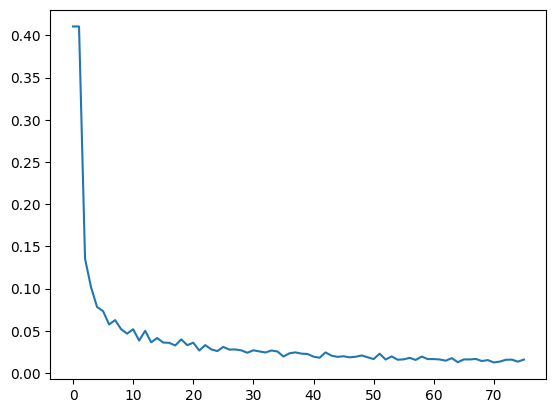

In [ ]:
parameters['reload'] = False

if not parameters['reload']:
    tr = time.time()
    model.train(True)
    for epoch in range(1, number_of_epochs + 1):
        for i, index in enumerate(np.random.permutation(len(train_data))):
            count += 1
            data = train_data[index]

            ##gradient updates for each data entry
            model.zero_grad()

            sentence_in = data['words']
            sentence_in = Variable(torch.LongTensor(sentence_in))
            tags = data['tags']
            chars2 = data['chars']

            # if parameters['char_mode'] == 'LSTM':
            #     chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
            #     d = {}
            #     for i, ci in enumerate(chars2):
            #         for j, cj in enumerate(chars2_sorted):
            #             if ci == cj and not j in d and not i in d.values():
            #                 d[j] = i
            #                 continue
            #     chars2_length = [len(c) for c in chars2_sorted]
            #     char_maxl = max(chars2_length)
            #     chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
            #     for i, c in enumerate(chars2_sorted):
            #         chars2_mask[i, :chars2_length[i]] = c
            #     chars2_mask = Variable(torch.LongTensor(chars2_mask))

            if parameters['char_mode'] == 'CNN':
                d = {}
                ## Padding the each word to max word size of that sentence
                chars2_length = [len(c) for c in chars2]
                char_maxl = max(chars2_length)
                chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
                for i, c in enumerate(chars2):
                    chars2_mask[i, :chars2_length[i]] = c
                chars2_mask = Variable(torch.LongTensor(chars2_mask))


            targets = torch.LongTensor(tags)

            #we calculate the negative log-likelihood for the predicted tags using the predefined function
            if use_gpu:
                neg_log_likelihood = model.neg_log_likelihood(sentence_in.cuda(), targets.cuda(), chars2_mask.cuda(), chars2_length)
            else:
                neg_log_likelihood = model.neg_log_likelihood(sentence_in, targets, chars2_mask, chars2_length)
            loss += neg_log_likelihood.data / len(data['words'])
            neg_log_likelihood.backward()

            #we use gradient clipping to avoid exploding gradients
            torch.nn.utils.clip_grad_norm(model.parameters(), gradient_clip)
            optimizer.step()

            #Storing loss
            if count % plot_every == 0:
                loss /= plot_every
                print(count, ': ', loss)
                if losses == []:
                    losses.append(loss)
                losses.append(loss)
                loss = 0.0

            #Evaluating on Train, Test, Dev Sets
            if count % (eval_every) == 0 and count > (eval_every * 20) or \
                    count % (eval_every*4) == 0 and count < (eval_every * 20):
                model.train(False)
                best_train_F, new_train_F, _ = evaluating(model, train_data, best_train_F,"Train")
                best_dev_F, new_dev_F, save = evaluating(model, dev_data, best_dev_F,"Dev")
                if save:
                    print(f"New best F1 score on validation set: {best_dev_F}")
                    print("Saving Model to ", model_name)
                    torch.save(model.state_dict(), model_name)
                # best_test_F, new_test_F, _ = evaluating(model, test_data, best_test_F,"Test")

                # all_F.append([new_train_F, new_dev_F, new_test_F])
                print(f"New F1 on Train: {new_train_F} - New F1 on Validation: {new_dev_F}")
                model.train(True)

            #Performing decay on the learning rate
            if count % len(train_data) == 0:
                adjust_learning_rate(optimizer, lr=learning_rate/(1+decay_rate*count/len(train_data)))

    print(time.time() - tr)
    losses_cpu = [loss_tensor.cpu().detach().numpy() for loss_tensor in losses]
    plt.plot(losses_cpu)
    plt.show()

if not parameters['reload']:
    #reload the best model saved from training
    model.load_state_dict(torch.load(model_name))

# Model Testing

This is where the model will be tested after training and evaluating process.

## First we need to load the best model which was saved during the training and evaluating process

In [ ]:
def LoadModel(modelPath):
  if not os.path.exists(parameters['reload']):
    print("Path lỗi, không load được.")
    return None
  loadModel = BiLSTM_CRF(vocab_size=len(word_to_id),
                   tag_to_ix=tag_to_id,
                   embedding_dim=parameters['word_dim'],
                   hidden_dim=parameters['word_lstm_dim'],
                   use_gpu=use_gpu,
                   char_to_ix=char_to_id,
                   pre_word_embeds=word_embeds,
                   use_crf=parameters['crf'],
                   char_mode=parameters['char_mode'],
                   char_out_dimension = 50)
  loadModel.load_state_dict(torch.load(modelPath))
  print("model reloaded :", modelPath)
  if use_gpu:
    loadModel.cuda()
  return loadModel

## Now we test the model

In [ ]:
%%capture
%cd /content/drive/MyDrive/NLP project

# Predict ở đây nha
# điền dữ liệu test vào dòng MakeSentences ở dưới này
path = './End-to-end-Sequence-Labeling-via-Bi-directional-LSTM-CNNs-CRF-Tutorial/models/model_word_version'
model = LoadModel(path)
another_txt = ""

for data in test_data:
    words = data['str_words']
    chars2 = data['chars']

    # Padding the each word to max word size of that sentence
    chars2_length = [len(c) for c in chars2]
    char_maxl = max(chars2_length)
    chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
    for i, c in enumerate(chars2):
        chars2_mask[i, :chars2_length[i]] = c
    chars2_mask = Variable(torch.LongTensor(chars2_mask))

    dwords = Variable(torch.LongTensor(data['words']))

    # We are getting the predicted output from our model
    if use_gpu:
        val,predicted_id = model(dwords.cuda(), chars2_mask.cuda(), chars2_length)
    else:
        val,predicted_id = model(dwords, chars2_mask, chars2_length)

    print('Predicted id: ', predicted_id)
    print('Words: ', words)

    # Group
    another_list_tags = ['NA'] * len(words)

    for index, tag in enumerate(predicted_id):
        for iob in tag_to_id:
            if tag_to_id[iob] == tag:
              another_list_tags[index] = iob
              break

    for word, tag in zip(words, another_list_tags):
        another_txt += word + ' ' + tag + '\n'

    another_txt += '\n'

# Group:
with open('./End-to-end-Sequence-Labeling-via-Bi-directional-LSTM-CNNs-CRF-Tutorial/evaluation/prediction_CnnBLSTMCrf_IOB.txt', 'w') as another_f:
  another_f.write(another_txt)
print("\nPrediction complete!!!")

# Draw the confusion matrix
- We first need to load the predicted data.
- Based on the predicted and ground-truth data, we will draw the confusion matrix

In [ ]:
# Define a function to read the labels
def get_labels(file_path):
  all_labels = []
  current_sentence = []

  file_format = (file_path.split('/')[-1]).split('.')[1]

  if file_format == 'conll':
    for line in codecs.open(file_path, 'r', 'utf-8'):
      line = line.strip()

      if not line:
        if len(current_sentence) != 0:
          all_labels.append(current_sentence)
          current_sentence = []
      else:
        # We only need the label therefore
        word, label = line.split()
        current_sentence.append(label)
    if len(current_sentence) != 0:
      all_labels.append(current_sentence)

  else:
    with open(file_path, 'r', encoding='utf-8') as f:
      for line in f:
        line = line.strip()

        if not line:
          if(len(current_sentence) != 0):
            all_labels.append(current_sentence)
            current_sentence = []
        else:
          word, label = line.split()
          current_sentence.append(label)

      if len(current_sentence) != 0:
        all_labels.append(current_sentence)

  return all_labels

In [ ]:
y_true = get_labels(parameters['test'])
y_pred = get_labels(r'./End-to-end-Sequence-Labeling-via-Bi-directional-LSTM-CNNs-CRF-Tutorial/evaluation/prediction_CnnBLSTMCrf_IOB.txt')

# print(y_true)
# print(y_pred)

print(f'Accuracy score: {accuracy_score(y_true, y_pred):.2f}')
print(f'Precision score: {precision_score(y_true, y_pred):.2f}')
print(f'Recall score: {recall_score(y_true, y_pred):.2f}')
print(f'F1 score: {f1_score(y_true, y_pred):.2f}')
print(f'\nDetailed report:\n{classification_report(y_true, y_pred)}')

Accuracy score: 0.96
Precision score: 0.92
Recall score: 0.89
F1 score: 0.91

Detailed report:
                     precision    recall  f1-score   support

                AGE       0.95      0.93      0.94       582
               DATE       0.97      0.97      0.97      1654
             GENDER       0.93      0.93      0.93       462
                JOB       0.66      0.50      0.57       173
           LOCATION       0.91      0.91      0.91      4441
               NAME       0.93      0.71      0.81       318
       ORGANIZATION       0.84      0.77      0.80       771
         PATIENT_ID       0.97      0.96      0.96      2005
SYMPTOM_AND_DISEASE       0.86      0.76      0.80      1136
     TRANSPORTATION       0.92      0.85      0.88       193

          micro avg       0.92      0.89      0.91     11735
          macro avg       0.89      0.83      0.86     11735
       weighted avg       0.92      0.89      0.90     11735

